In [2]:
# Baysian Linear Regression
# The data/example used here comes from the "Bayesian Analysis Techniques" course on coursera.
# Actual data comes from R datasets... to reproduce, download the Leinhardt dataset from R package `car`

using DataFrames
using CSV
using GLM
using RCall
using Plots
#using PyPlot
using Mamba 
using StatsPlots
using DelimitedFiles
using LinearAlgebra
pwd()

┌ Info: Precompiling GLM [38e38edf-8417-5370-95a0-9cbb8c7f171a]
└ @ Base loading.jl:1260
┌ Info: Precompiling Mamba [5424a776-8be3-5c5b-a13f-3551f69ba0e6]
└ @ Base loading.jl:1260
┌ Info: Precompiling StatsPlots [f3b207a7-027a-5e70-b257-86293d7955fd]
└ @ Base loading.jl:1260


"/mnt/c/Users/affan/OneDrive/Documents/postdoc projects/learning_notes/regression_models"

In [3]:
## CSV 0.7 is severely broken with other pacakges
dat = (CSV.File("./Leinhardt.csv")) |> DataFrame

#dat = readdlm("./Leinhardt.csv", ',', header=false, skipstart=1) |> DataFrame
#rename!(dat, [:income, :infant, :region, :oil])
#convert(Float64, dat.infant)
#dat[!,:infant] = convert.(Float64,dat[!,:infant])
# dat.infant = passmissing(parse).(Float64, dat.infant)
cols = Symbol.(names(dat))

println(eltype.(eachcol(dat)))
println(typeof(dat.infant))
dat

Type[Int64, Union{Missing, Float64}, String, String]
Array{Union{Missing, Float64},1}


,income,infant,region,oil
,Int64,Float64?,String,String
1,3426,26.7,Asia,no
2,3350,23.7,Europe,no
3,3346,17.0,Europe,no
4,4751,16.8,Americas,no
5,5029,13.5,Europe,no
6,3312,10.1,Europe,no
7,3403,12.9,Europe,no
8,5040,20.4,Europe,no
9,2009,17.8,Europe,no


In [6]:
## Lets remove the missing values
dropmissing!(dat, disallowmissing=true)
disallowmissing!(dat)
eltype.(eachcol(dat))
#using TableView
#showtable(dat)

4-element Array{DataType,1}:
 Int64
 Float64
 String
 String

trigger


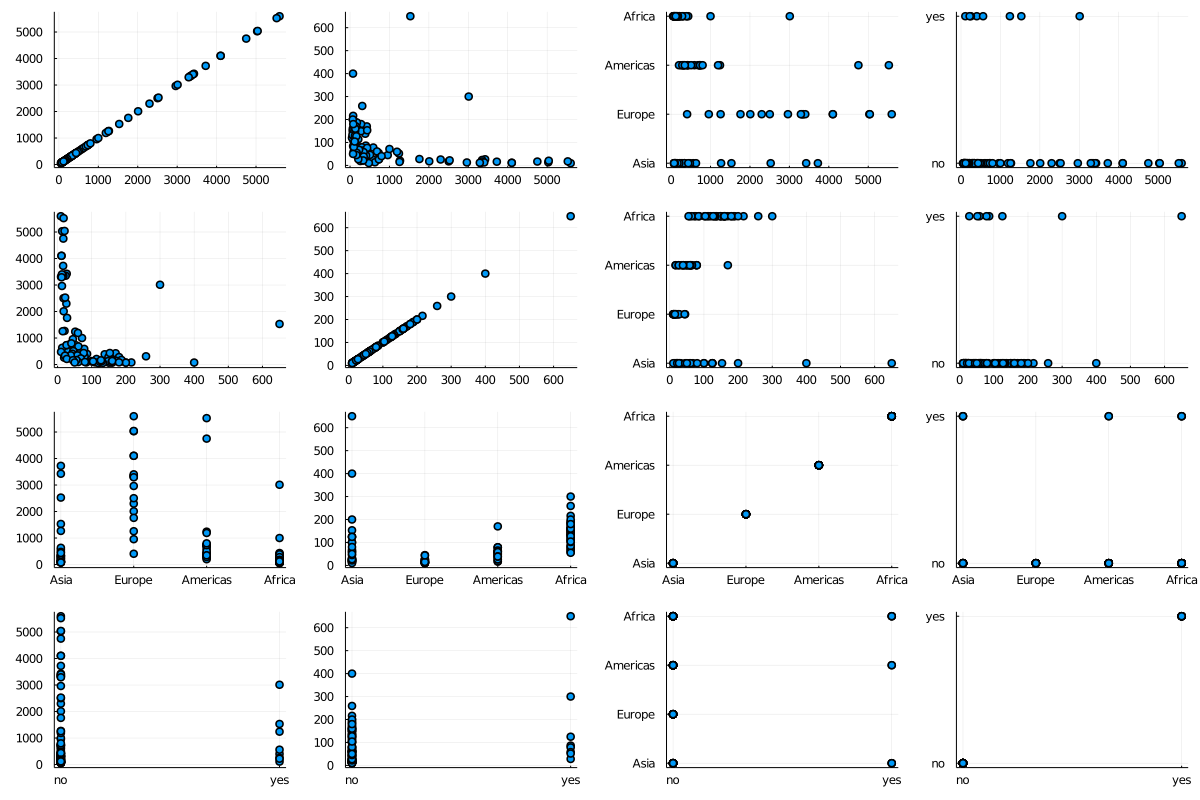

In [7]:
## plot the data using plots
#dat = CSV.File("./Leinhardt.csv") |> DataFrame
(nobs, nvars) = size(dat)
l = @layout grid(4,4)
plots = Plots.Plot{Plots.GRBackend}[]
println("trigger")
# Plot data for visual inspection
for i = 1:nvars
    for j = 1:nvars
        p = @df dat scatter(cols(cols[i]), cols(cols[j]))
        push!(plots, p)
    end
end
Plots.plot(plots..., layout=l, legend=false, size=(1200, 800))

,income,infant,region,oil,logincome,loginfant
,Int64,Float64,String,String,Float64,Float64
1,3426,26.7,Asia,no,8.13915,3.28466
2,3350,23.7,Europe,no,8.11672,3.16548
3,3346,17.0,Europe,no,8.11552,2.83321
4,4751,16.8,Americas,no,8.46611,2.82138
5,5029,13.5,Europe,no,8.52298,2.60269
6,3312,10.1,Europe,no,8.10531,2.31254
7,3403,12.9,Europe,no,8.13241,2.55723
8,5040,20.4,Europe,no,8.52516,3.01553
9,2009,17.8,Europe,no,7.60539,2.8792


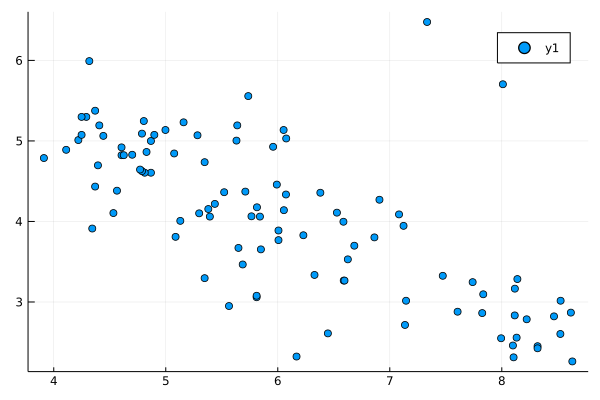

In [8]:
## data is very right skewed, so lets take the log of the continous variables. 

@. dat[!, :logincome] = passmissing(log)((dat[:, :income]))
@. dat[!, :loginfant] = passmissing(log)((dat[:, :infant]))
display(dat)

## lets plot two of the covariates to see the effect of log
p = @df dat scatter(:logincome, :loginfant)
display(p)


In [9]:
## Lets do a simple model (i.e. something with really flat, non informative priors, i.e. basically a basic linear regression)
## define a linear model
lmod = lm(@formula(loginfant ~ logincome), dat)
#dat.infant
display(lmod)
display(deviance(lmod))
display(r2(lmod))

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

loginfant ~ 1 + logincome

Coefficients:
────────────────────────────────────────────────────────────────────────────
              Estimate  Std. Error   t value  Pr(>|t|)  Lower 95%  Upper 95%
────────────────────────────────────────────────────────────────────────────
(Intercept)   7.14582    0.31654    22.5748     <1e-40   6.51774    7.77391
logincome    -0.511794   0.0512193  -9.99222    <1e-15  -0.613424  -0.410164
────────────────────────────────────────────────────────────────────────────

46.68519534269639

0.50212361972335

In [41]:
## Lets do Mamba MCMC

## The model has a few stochastic nodes, and mu is a deterministic mode based on linear combination of beta and x values
model = Model(
  y = Stochastic(1,
    (μ, σ2) ->  MvNormal(μ, sqrt(σ2)),
    false
  ),

  μ = Logical(1,
    (xmat, β) ->  xmat * β ,
    false
  ),

  # use a common univariate Normal for the beta values.
  # the "1, " the first argument says that beta is an array
  β =  Stochastic(1,
    () -> Normal(0, 100)
  ),
    
  σ2 = Stochastic(
    () -> InverseGamma(2.5, 25)
  )
)
## Set up the samplers. We can use NUST 
## Need to sample beta and sigma values
scheme2 = [NUTS([Symbol("β"), Symbol("σ2")])]
setsamplers!(model, scheme2)

Object of type "Model"
-------------------------------------------------------------------------------
μ:
An unmonitored node of type "0-element ArrayLogical{1}"
Float64[]
-------------------------------------------------------------------------------
y:
An unmonitored node of type "0-element ArrayStochastic{1}"
Float64[]
-------------------------------------------------------------------------------
β:
A monitored node of type "0-element ArrayStochastic{1}"
Float64[]
-------------------------------------------------------------------------------
σ2:
A monitored node of type "ScalarStochastic"
NaN


In [42]:
# can we show the DAG?
draw(model)

digraph MambaModel {
	"μ" [shape="diamond", style="filled", fillcolor="gray85"];
		"μ" -> "y";
	"xmat" [shape="box", style="filled", fillcolor="gray85"];
		"xmat" -> "μ";
	"β" [shape="ellipse"];
		"β" -> "μ";
	"y" [shape="ellipse", style="filled", fillcolor="gray85"];
	"σ2" [shape="ellipse"];
		"σ2" -> "y";
}


In [53]:
## lets start giving initial conditions 

## lets organize the data
## line stores the observed data. 
line = Dict{Symbol, Any}(
  :x => dat.logincome,
  :y => dat.loginfant
)

# turn the :x to a matrix 
# the names have to match as in the column
line[:xmat] = [ones(nrow(dat)) line[:x]]

display(line[:xmat])

# set up initial values 
# we want three chains, so three sets of initial values
inits = [
  Dict{Symbol, Any}(
    :y => line[:y],   # have to use the data for 
    :β  => rand(Normal(1, 1), 2),
    :σ2 => rand(InverseGamma(2.5, 25))
  )
for i in 1:3   
]

sim1 = mcmc(model, line, inits, 10000, burnin=1000, thin=5, chains=3)

101×2 Array{Float64,2}:
 1.0  8.13915
 1.0  8.11672
 1.0  8.11552
 1.0  8.46611
 1.0  8.52298
 1.0  8.10531
 1.0  8.13241
 1.0  8.52516
 1.0  7.60539
 1.0  7.73979
 1.0  8.09925
 1.0  8.31947
 1.0  8.22229
 ⋮    
 1.0  4.11087
 1.0  4.99721
 1.0  4.44265
 1.0  5.0876
 1.0  4.82831
 1.0  4.78749
 1.0  5.07517
 1.0  4.89784
 1.0  4.40672
 1.0  4.56435
 1.0  4.34381
 1.0  4.77068

MCMC Simulation of 10000 Iterations x 3 Chains...

Chain 1:   0% [0:00:03 of 0:00:03 remaining]
Chain 1:  10% [0:00:06 of 0:00:06 remaining]
Chain 1:  20% [0:00:05 of 0:00:07 remaining]
Chain 1:  30% [0:00:05 of 0:00:07 remaining]
Chain 1:  40% [0:00:04 of 0:00:07 remaining]
Chain 1:  50% [0:00:04 of 0:00:07 remaining]
Chain 1:  60% [0:00:03 of 0:00:07 remaining]
Chain 1:  70% [0:00:02 of 0:00:08 remaining]
Chain 1:  80% [0:00:01 of 0:00:07 remaining]
Chain 1:  90% [0:00:01 of 0:00:07 remaining]
Chain 1: 100% [0:00:00 of 0:00:07 remaining]

Chain 2:   0% [0:00:04 of 0:00:04 remaining]
Chain 2:  10% [0:00:07 of 0:00:07 remaining]
Chain 2:  20% [0:00:06 of 0:00:08 remaining]
Chain 2:  30% [0:00:05 of 0:00:08 remaining]
Chain 2:  40% [0:00:04 of 0:00:07 remaining]
Chain 2:  50% [0:00:04 of 0:00:07 remaining]
Chain 2:  60% [0:00:03 of 0:00:08 remaining]
Chain 2:  70% [0:00:03 of 0:00:09 remaining]
Chain 2:  80% [0:00:02 of 0:00:09 remaining]
Chain 2:  90% [0:00:01 of 0:00:09 remaining]
Cha

Object of type "ModelChains"

Iterations = 1005:10000
Thinning interval = 5
Chains = 1,2,3
Samples per chain = 1800

[0.7402489127224512 7.207011059471412 -0.5151675215717832; 0.8568590019335618 7.08372189389616 -0.514073621237433; … ; 0.9396615780231241 6.727623148600075 -0.43426958962427475; 0.7664796782929513 6.743653552858828 -0.47129982412015875]

[1.1380666228632759 6.9410814369490526 -0.46550705312289303; 1.0614598169921388 6.781036727958329 -0.4536661705818652; … ; 0.9559537673139071 6.7814684909443015 -0.445357714372021; 0.8993751062403057 6.776039990421349 -0.45481724974028603]

[1.0062483911441407 6.999161360985048 -0.4708234639047495; 1.1908407755039 7.046440525920048 -0.46592188726372513; … ; 0.9749438279845646 6.9577350806273355 -0.4902367955347148; 0.9015156836109038 7.006357000672801 -0.5054188409263656]

In [54]:
## Posterior Inference 
gelmandiag(sim1, mpsrf=true, transform=true) |> Mamba.showall

Iterations = 1005:10000
Thinning interval = 5
Chains = 1,2,3
Samples per chain = 1800

Gelman, Rubin, and Brooks Diagnostic:
             PSRF 97.5%
          σ2    1     1
        β[1]    1     1
        β[2]    1     1
Multivariate    1   NaN



In [56]:
describe(sim1)
println("HPD: \n $(hpd(sim1))")

## Cross-Correlations
println("Cross Corr: \n $(cor(sim1))")

## Autocorrelations in the chains
## Correlation in early lags (i.e close to -1 or 1) tells us to look at our effective size
## and maybe thin out the chains.
println("Auto Corr: \n $(autocor(sim1))")

## State Space Change Rate (per Iteration)
println("State Space Change Rate: \n $(changerate(sim1))")

## Deviance Information Criterion
println("Deviance: \n $(dic(sim1))")

Iterations = 1005:10000
Thinning interval = 5
Chains = 1,2,3
Samples per chain = 1800

Empirical Posterior Estimates:
         Mean        SD       Naive SE       MCSE      ESS
  σ2  0.94716258 0.13563253 0.0018457249 0.0019295065 1800
β[1]  7.13636513 0.45861846 0.0062410068 0.0093284339 1800
β[2] -0.51050789 0.07450907 0.0010139400 0.0014794734 1800

Quantiles:
         2.5%       25.0%       50.0%      75.0%       97.5%  
  σ2  0.71369191  0.85058994  0.9365249  1.03086644  1.2426836
β[1]  6.21349515  6.83402158  7.1346129  7.44695778  8.0318031
β[2] -0.65348835 -0.56110184 -0.5103612 -0.46109483 -0.3600223

HPD: 
       95% Lower   95% Upper 
  σ2  0.69749326  1.22002218
β[1]  6.27770760  8.08840358
β[2] -0.65221767 -0.35922287


Cross Corr: 
           σ2          β[1]         β[2]    
  σ2  1.000000000 -0.016221768  0.010255888
β[1] -0.016221768  1.000000000 -0.977134798
β[2]  0.010255888 -0.977134798  1.000000000


Auto Corr: 
          Lag 5        Lag 25        Lag 50       La

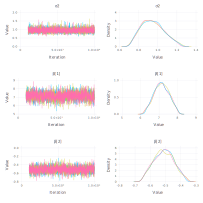

In [57]:
## Plot the trace and posteriors.
p = Mamba.plot(sim1)
draw(p)

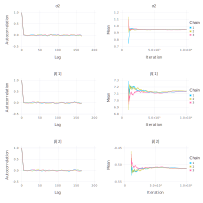

In [58]:
## Autocorrelation and running mean plots
pac = Mamba.plot(sim1, [:autocor, :mean], legend=true)
draw(pac, nrow=3, ncol=2)

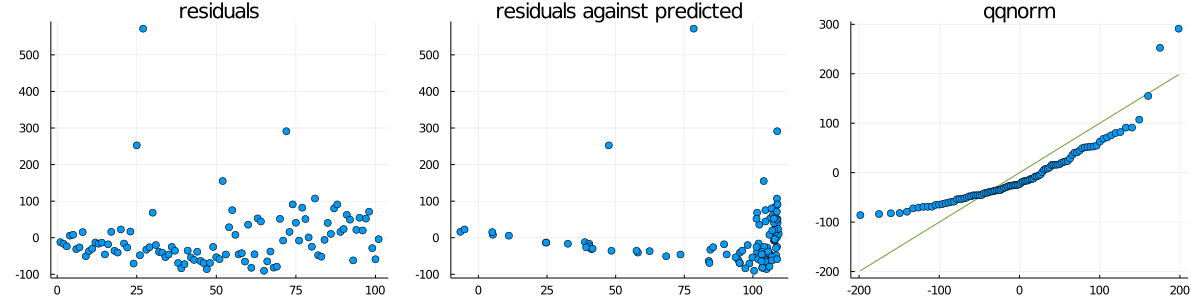

In [59]:
## Lets do some residual checks
## Checking residuals (the difference between the response and the model’s prediction for that value) is important with linear models 
## since residuals can reveal violations of the assumptions we made to specify the model. In particular, we are looking for any 
## sign that the model is not linear, normally distributed, or that the observations are not independent (conditional on covariates).

## lets look at the residuals of the reference linear model to the **untransformed** variables.
lmod0 = lm(@formula(infant ~ income), dat)

# plot the residuals to check for indepedence, looks okay actually. 
resid = dat.infant .- predict(lmod0)
p1 = Plots.scatter(1:nrow(dat), resid, title="residuals", legend=false)

# plot the residuals against the predicted values to check for linearity...
p2 = Plots.scatter(predict(lmod0), resid, title="residuals against predicted", legend=false) # constant variance (looks bad)

# to check Normality assumption (we want this to be a straight line)
p3 = qqnorm(resid, predict(lmod0), title="qqnorm") # note that its not a straight line. looks ike its increasing. .. so our untransformed data dosn't seem normal

Plots.plot(p1, p2, p3, layout=(1, 3), size=(1200, 300))

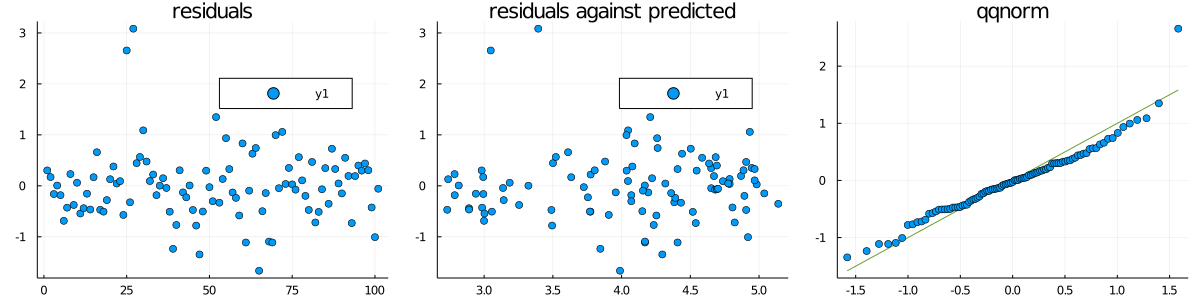

In [60]:
# calculate the mean of each point  which is beta * X mat
model_betavalues =  mean(sim1.value[:, :, 1], dims=1)[2:3] # using only chain 1 to get the mean value for beta0 and beta1
bay_predicted = line[:xmat] * model_betavalues
bay_resid = dat.loginfant - bay_predicted
# plot the residuals
p1 = Plots.scatter(bay_resid, title="residuals")

# plot the residuals against the predicted values to check for linearity...
p2 = Plots.scatter(bay_predicted, bay_resid, title="residuals against predicted")

# and more importantly, check the qq plot to check for normality
p3 = qqnorm(bay_resid, bay_predicted, title="qqnorm") # a fairly straight line now.

Plots.plot(p1, p2, p3, layout=(1, 3), size=(1200, 300))

# in these plots, we see that two outliers appear (from data, this Saudi Arabia and Libya.)
# can we take care of these outliers? Maybe use an additional covariate.

In [65]:
## Since the `model` is defined in terms of vectors, we don't really need to do anything to include other covariates. 
## The model simply multiple beta * xmat 
## and the sampler is already setup to sample the beta array. 

## we just need to modify our data slightly.
## lets convert the "yes"/"no" to bitarray
oil_data = dat.oil .== "yes"

line = Dict{Symbol, Any}(
  :x1 => dat.logincome,
  :x2 => oil_data,
  :y => dat.loginfant
)

# turn the :x to a matrix 
# the names have to match as in the column
line[:xmat] = [ones(nrow(dat)) line[:x1] line[:x2]]

display(line[:xmat])

## nothing really changes for the inits except now we sample 3 initial numbers for beta (intercept, x1, x2)
inits = [
  Dict{Symbol, Any}(
    :y => line[:y],   # have to use the data for 
    :β  => rand(Normal(1, 1), 3),
    :σ2 => rand(InverseGamma(2.5, 25))
  )
for i in 1:3   
]
sim2 = mcmc(model, line, inits, 10000, burnin=1000, thin=5, chains=3)


101×3 Array{Float64,2}:
 1.0  8.13915  0.0
 1.0  8.11672  0.0
 1.0  8.11552  0.0
 1.0  8.46611  0.0
 1.0  8.52298  0.0
 1.0  8.10531  0.0
 1.0  8.13241  0.0
 1.0  8.52516  0.0
 1.0  7.60539  0.0
 1.0  7.73979  0.0
 1.0  8.09925  0.0
 1.0  8.31947  0.0
 1.0  8.22229  0.0
 ⋮             
 1.0  4.11087  0.0
 1.0  4.99721  0.0
 1.0  4.44265  0.0
 1.0  5.0876   0.0
 1.0  4.82831  0.0
 1.0  4.78749  0.0
 1.0  5.07517  0.0
 1.0  4.89784  0.0
 1.0  4.40672  0.0
 1.0  4.56435  0.0
 1.0  4.34381  0.0
 1.0  4.77068  0.0

MCMC Simulation of 10000 Iterations x 3 Chains...

Chain 1:   0% [0:00:19 of 0:00:19 remaining]
Chain 1:  10% [0:00:12 of 0:00:13 remaining]
Chain 1:  20% [0:00:11 of 0:00:13 remaining]
Chain 1:  30% [0:00:09 of 0:00:13 remaining]
Chain 1:  40% [0:00:08 of 0:00:13 remaining]
Chain 1:  50% [0:00:06 of 0:00:13 remaining]
Chain 1:  60% [0:00:05 of 0:00:13 remaining]
Chain 1:  70% [0:00:04 of 0:00:14 remaining]
Chain 1:  80% [0:00:03 of 0:00:14 remaining]
Chain 1:  90% [0:00:01 of 0:00:14 remaining]
Chain 1: 100% [0:00:00 of 0:00:15 remaining]

Chain 2:   0% [0:00:09 of 0:00:09 remaining]
Chain 2:  10% [0:00:16 of 0:00:17 remaining]
Chain 2:  20% [0:00:13 of 0:00:17 remaining]
Chain 2:  30% [0:00:12 of 0:00:17 remaining]
Chain 2:  40% [0:00:10 of 0:00:17 remaining]
Chain 2:  50% [0:00:09 of 0:00:18 remaining]
Chain 2:  60% [0:00:07 of 0:00:17 remaining]
Chain 2:  70% [0:00:05 of 0:00:17 remaining]
Chain 2:  80% [0:00:04 of 0:00:18 remaining]
Chain 2:  90% [0:00:02 of 0:00:17 remaining]
Cha

Object of type "ModelChains"

Iterations = 1005:10000
Thinning interval = 5
Chains = 1,2,3
Samples per chain = 1800

[0.7945976697070635 6.85828774730448 -0.480730806356349 0.20708111794430017; 1.0018653676960834 7.009220383018656 -0.5185276261038549 1.0243020237428058; … ; 0.8436050719445853 6.891673995368388 -0.49461575178426553 1.40727917290094; 1.195480005413392 8.079412079943038 -0.6711898746014303 1.359552733445871]

[1.1064346078882517 6.537361165974618 -0.40595444333657704 0.18824021097025626; 1.0076863377442995 7.014102603112293 -0.4852510569987919 0.35735581665001825; … ; 1.1735924912661764 6.688612056552668 -0.479426048276926 0.7551927344595882; 0.7545015036244893 7.186607896392667 -0.5212205884376585 0.7030760595456333]

[1.062919398364032 6.673756796673108 -0.43423045158073587 0.6474933082392961; 1.0101109230827108 6.551671405878893 -0.4223300885224641 0.941643568736792; … ; 0.8736546576619535 6.374652684898834 -0.40873473639117913 1.3136805001977274; 0.7588066397477259 6.

In [68]:
describe(sim2)
println("HPD: \n $(hpd(sim2))")

## Posterior Inference 
display(gelmandiag(sim2, mpsrf=true, transform=true) |> Mamba.showall)

## Cross-Correlations
println("Cross Corr: \n $(cor(sim2))")

## Autocorrelations in the chains
## Correlation in early lags (i.e close to -1 or 1) tells us to look at our effective size
## and maybe thin out the chains.
println("Auto Corr: \n $(autocor(sim2))")

## State Space Change Rate (per Iteration)
println("State Space Change Rate: \n $(changerate(sim2))")

## Deviance Information Criterion
println("Deviance: \n $(dic(sim2))")

nothing

Iterations = 1005:10000
Thinning interval = 5
Chains = 1,2,3
Samples per chain = 1800

Empirical Posterior Estimates:
         Mean        SD       Naive SE       MCSE      ESS
  σ2  0.91115091 0.12734769 0.0017329825 0.0018089202 1800
β[1]  7.13841021 0.44345102 0.0060346040 0.0050731796 1800
β[2] -0.52093073 0.07188594 0.0009782438 0.0008573829 1800
β[3]  0.78673596 0.35200174 0.0047901369 0.0049968719 1800

Quantiles:
         2.5%       25.0%       50.0%       75.0%       97.5%   
  σ2  0.69855347  0.82185655  0.89995330  0.98930366  1.18694110
β[1]  6.29468603  6.83602510  7.13823143  7.43530836  8.03609305
β[2] -0.66678825 -0.56956782 -0.52134150 -0.47247957 -0.38192686
β[3]  0.09593301  0.55036284  0.79076574  1.02336609  1.47228593

HPD: 
       95% Lower   95% Upper 
  σ2  0.68664025  1.16812893
β[1]  6.32716565  8.05993936
β[2] -0.65842662 -0.37820642
β[3]  0.09512373  1.47225912


Iterations = 1005:10000
Thinning interval = 5
Chains = 1,2,3
Samples per chain = 1800

Gelman, 

WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[""], Dict{Symbol,Any}(:style => Dict("height" => "0","padding" => "0","background-color" => "#F5F7F7","color" => "#1c1f20","font-family" => "-apple-system, BlinkMacSystemFont, \"Segoe UI\", Roboto, Oxygen-Sans, Ubuntu, Cantarell, \"Helvetica Neue\", sans-serif"))), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[], Dict{Symbol,Any}(:id => "grid-0cb6dbce",:className => "ag-theme-balham",:style => Dict("height" => "500px","width" => "100%")))], Dict{Symbol,Any}()), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("onCellKeyDown" => (Observable{Any} with 0 listeners. Value:
nothing, nothing),"onRowClicked" => (Observable{Any} with 0 listeners. Value:
nothing, nothing),"onCellDoubleClicked" => (Observable{Any} with 0 listeners. Value:
nothing, nothing),"requestedrows" => (Observable{JSON.Writer.JSONText} with 1 listeners. Value:
JSON.Writer.JSONText("{}"), nothing),"onCellClicked" => (Observable{Any} with 0 listeners. Value:
nothing, nothing),"onCellFocused" => (Observable{Any} with 0 listeners. Value:
nothing, nothing),"rowparams" => (Observable{Dict{String,Any}} with 1 listeners. Value:
Dict{String,Any}("successCallback" => WebIO.JSString("(function (v){return null})"),"startRow" => 1,"endRow" => 100), nothing)), Set(String[]), nothing, WebIO.Asset[WebIO.Asset("js", nothing, "/home/affan/.julia/packages/TableView/1D3rM/src/rowNumberRenderer.js"), WebIO.Asset("js", nothing, "/home/affan/.julia/packages/TableView/1D3rM/deps/ag-grid-22.1.0/ag-grid.js"), WebIO.Asset("css", nothing, "/home/affan/.julia/packages/TableView/1D3rM/deps/ag-grid-22.1.0/ag-grid.css"), WebIO.Asset("css", nothing, "/home/affan/.julia/packages/TableView/1D3rM/deps/ag-grid-22.1.0/ag-grid-light.css"), WebIO.Asset("css", nothing, "/home/affan/.julia/packages/TableView/1D3rM/deps/ag-grid-22.1.0/ag-grid-dark.css")], Dict{Any,Any}("requestedrows" => Any[WebIO.JSString("(function (val){return WebIO.getval({\"name\":\"rowparams\",\"scope\":\"8693847355862675029\",\"id\":\"14879859964912203307\",\"type\":\"observable\"}).successCallback(val,null)})")]), WebIO.ConnectionPool(Channel{Any}(sz_max:32,sz_curr:0), Set(WebIO.AbstractConnection[]), Base.GenericCondition{Base.AlwaysLockedST}(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007fdb88b730d0, Task (runnable) @0x00007fdb88b730d0), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = ((function (RowNumberRenderer,agGrid){var gridOptions={\"onCellFocused\":(function (ev){var x={}; (ev.rowIndex!==undefined) ? (x[\"rowIndex\"]=(ev.rowIndex+1)) : undefined; (ev.colDef!==undefined) ? (x[\"column\"]=ev.colDef.headerName) : undefined; return WebIO.setval({\"name\":\"onCellFocused\",\"scope\":\"8693847355862675029\",\"id\":\"14302513645917868557\",\"type\":\"observable\"},x)}),\"onCellValueChanged\":(function (){return }),\"rowModelType\":\"infinite\",\"onRowClicked\":(function (ev){var x={}; (ev.rowIndex!==undefined) ? (x[\"rowIndex\"]=(ev.rowIndex+1)) : undefined; (ev.colDef!==undefined) ? (x[\"column\"]=ev.colDef.headerName) : undefined; return WebIO.setval({\"name\":\"onRowClicked\",\"scope\":\"8693847355862675029\",\"id\":\"1761107682187836254\",\"type\":\"observable\"},x)}),\"maxConcurrentDatasourceRequests\":1,\"columnDefs\":[{\"filter\":false,\"editable\":false,\"headerTooltip\":\"\",\"field\":\"__row__\",\"headerName\":\"Row\",\"sortable\":false,\"type\":\"numericColumn\",\"cellRenderer\":\"rowNumberRenderer\",\"resizable\":true},{\"filter\":false,\"editable\":false,\"headerTooltip\":\"Int64\",\"field\":\"income\",\"headerName\":\"income\",\"sortable\":false,\"type\":\"numericColumn\",\"resizable\":true},{\"filter\":false,\"editable\":false,\"headerTooltip\":\"Float64\",\"field\":\"infant\",\"headerName\":\"infant\",\"sortable\":false,\"type\":\"numericColumn\",\"resizable\":true},{\"filter\":false,\"editable\":false,\"headerTooltip\":\"String

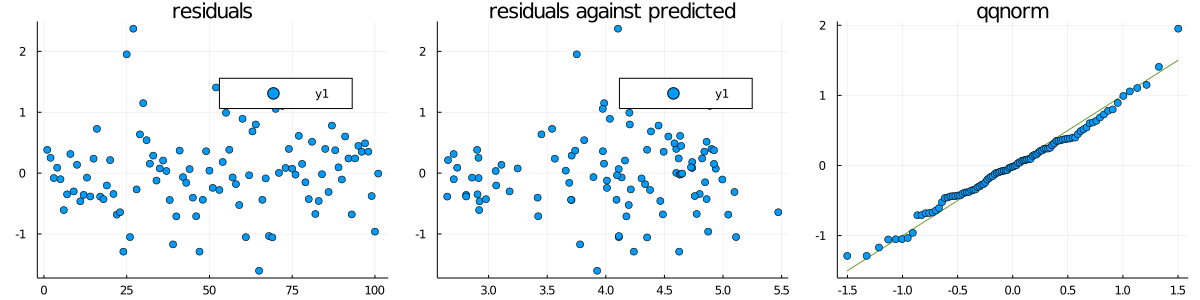

In [75]:
# calculate the mean of each point  which is beta * X mat
model_betavalues =  mean(sim2.value[:, :, 1], dims=1)[2:4] # using only chain 1 to get the mean value for beta0 and beta1
bay_predicted = line[:xmat] * model_betavalues
bay_resid = dat.loginfant - bay_predicted
# plot the residuals
p1 = Plots.scatter(bay_resid, title="residuals")

# plot the residuals against the predicted values to check for linearity...
p2 = Plots.scatter(bay_predicted, bay_resid, title="residuals against predicted")

# and more importantly, check the qq plot to check for normality
p3 = qqnorm(bay_resid, bay_predicted, title="qqnorm") # a fairly straight line now.

Plots.plot(p1, p2, p3, layout=(1, 3), size=(1200, 300))

# These look much better, although the residuals for Saudi Arabia and Libya are still more than three standard deviations away
# from the mean of the residuals. We might consider adding the other covariate region, but instead let’s look at another option when we are faced with strong outliers.

In [80]:
## Compare the two models using Deviance Information Criteria
display(dic(sim1))
display(dic(sim2))

MCMC Processing of 1800 Iterations x 3 Chains...

Chain 1:   1% [0:00:00 of 0:00:00 remaining]
Chain 1:  10% [0:00:00 of 0:00:00 remaining]
Chain 1:  20% [0:00:00 of 0:00:00 remaining]
Chain 1:  30% [0:00:00 of 0:00:00 remaining]
Chain 1:  40% [0:00:00 of 0:00:00 remaining]
Chain 1:  50% [0:00:00 of 0:00:00 remaining]
Chain 1:  60% [0:00:00 of 0:00:00 remaining]
Chain 1:  70% [0:00:00 of 0:00:00 remaining]
Chain 1:  80% [0:00:00 of 0:00:00 remaining]
Chain 1:  90% [0:00:00 of 0:00:00 remaining]
Chain 1: 100% [0:00:00 of 0:00:00 remaining]

Chain 2:   1% [0:00:02 of 0:00:02 remaining]
Chain 2:  10% [0:00:00 of 0:00:00 remaining]
Chain 2:  20% [0:00:00 of 0:00:00 remaining]
Chain 2:  30% [0:00:00 of 0:00:00 remaining]
Chain 2:  40% [0:00:00 of 0:00:00 remaining]
Chain 2:  50% [0:00:00 of 0:00:00 remaining]
Chain 2:  60% [0:00:00 of 0:00:00 remaining]
Chain 2:  70% [0:00:00 of 0:00:00 remaining]
Chain 2:  80% [0:00:00 of 0:00:00 remaining]
Chain 2:  90% [0:00:00 of 0:00:00 remaining]
Chai

      DIC    Effective Parameters
pD 233.50534            2.0361726
pV 287.78313           29.1750660



      DIC    Effective Parameters
pD 228.36417            2.9637185
pV 284.69687           31.1300652




MCMC Processing of 1800 Iterations x 3 Chains...

Chain 1:   1% [0:00:00 of 0:00:00 remaining]
Chain 1:  10% [0:00:00 of 0:00:00 remaining]
Chain 1:  20% [0:00:00 of 0:00:00 remaining]
Chain 1:  30% [0:00:00 of 0:00:00 remaining]
Chain 1:  40% [0:00:00 of 0:00:00 remaining]
Chain 1:  50% [0:00:00 of 0:00:00 remaining]
Chain 1:  60% [0:00:00 of 0:00:00 remaining]
Chain 1:  70% [0:00:00 of 0:00:00 remaining]
Chain 1:  80% [0:00:00 of 0:00:00 remaining]
Chain 1:  90% [0:00:00 of 0:00:00 remaining]
Chain 1: 100% [0:00:00 of 0:00:00 remaining]

Chain 2:   1% [0:00:04 of 0:00:04 remaining]
Chain 2:  10% [0:00:00 of 0:00:00 remaining]
Chain 2:  20% [0:00:00 of 0:00:00 remaining]
Chain 2:  30% [0:00:00 of 0:00:00 remaining]
Chain 2:  40% [0:00:00 of 0:00:00 remaining]
Chain 2:  50% [0:00:00 of 0:00:00 remaining]
Chain 2:  60% [0:00:00 of 0:00:00 remaining]
Chain 2:  70% [0:00:00 of 0:00:00 remaining]
Chain 2:  80% [0:00:00 of 0:00:00 remaining]
Chain 2:  90% [0:00:00 of 0:00:00 remaining]
Cha